# Ejemplo de modelo en Pringles

### 1. Discover del codigo de atomicos

Empezamos con los modelos construidos en user_models/ . En este caso tenemos:

In [1]:
!find user_models/ -name "*.h"

user_models/constants.h
user_models/paranoia.h
user_models/vacunatorio.h
user_models/poblacion.h
user_models/contagio.h
user_models/helpers.h
user_models/sist_prevencion.h
user_models/foco.h


In [2]:
from pringles.simulator import Simulator

In [4]:
simulator = Simulator("user_models/")
r = simulator.get_registry()

Todas estas clases que heredan de Atomic fueron creadas automaticamente a partir del codigo fuente

In [7]:
r.discovered_atomics

AttributeError: 'AtomicRegistry' object has no attribute 'discovered_atomics'

Y cada una puede ser accedida asi:

In [5]:
r.Paranoia

colonel.models.models.Paranoia

### 2. Construir el modelo usando la interfaz en python

In [6]:
from pringles.models import Coupled

In [7]:
def crear_interacciones_poblacion(mean=2, std=1, threshold_NV=30, threshold_V=80):
    # Los atomicos ya tienen los puertos definidos a partir de leer la metadata del codigo
    un_foco = r.Foco("foco", mean=mean, std=std)
    un_contagio = r.Contagio("contagio", threshold_NV=threshold_NV, threshold_V=threshold_V)

    interacciones_poblacion = (Coupled("interacciones_poblacion", [un_foco, un_contagio])
        .add_inport("in_port")
        .add_outport("out_port")
        .add_coupling("in_port", un_foco.get_port("in"))
        .add_coupling(un_foco.get_port("out"), un_contagio.get_port("in"))
        .add_coupling(un_contagio.get_port("out"), "out_port"))
    return interacciones_poblacion

In [8]:
interacciones_pob = crear_interacciones_poblacion()

In [9]:
from pringles.display import ModelDisplay

In [10]:
ModelDisplay(interacciones_pob)

In [13]:
def crear_sist_vacunacion(p_inf_NV=0.3, p_inf_V=0.8, alpha=2, cant_vacunas_por_dia_activo=10000, prop_infectados_inicio=0.1, prop_infectados_cierre=0.025):
    un_sist_prevencion = r.SistPrevencion("sist_prevencion", prop_infectados_inicio=prop_infectados_inicio, prop_infectados_cierre=prop_infectados_cierre)
    un_vacunatorio = r.Vacunatorio("vacunatorio", cant_vacunas_por_dia_activo=cant_vacunas_por_dia_activo)
    un_paranoia = r.Paranoia("paranoia", p_inf_NV=p_inf_NV, p_inf_V=p_inf_V, alpha=alpha)
    
    sist_vacunacion = (Coupled("sist_vacunacion", [un_sist_prevencion, un_vacunatorio, un_paranoia])
        .add_inport('in_port')
        .add_outport('out_port')
        .add_coupling('in_port', un_paranoia.get_port("in"))
        .add_coupling('in_port', un_sist_prevencion.get_port("in"))
        .add_coupling(un_paranoia.get_port("out"), un_vacunatorio.get_port("in_pacientes"))
        .add_coupling(un_sist_prevencion.get_port("out"), un_vacunatorio.get_port("in_activo"))
        .add_coupling(un_vacunatorio.get_port("out"), "out_port")
    )
    return sist_vacunacion

In [14]:
sist_vac = crear_sist_vacunacion()

PortNotFoundException: in_pacientes

In [13]:
ModelDisplay(sist_vac)

In [14]:
def crear_top(susceptibles_nv=547250, susceptibles_v=447750,
              infectados_nv=2750, infectados_v=2250,
              recuperados_nv=0, recuperados_v=0,
              vacunados_nv=0, vacunados_v=0,
              proba_sana_nv=0.2, proba_sana_v=0.1):
    pobl = r.Poblacion("poblacion",
            susceptibles_nv=susceptibles_nv,
            susceptibles_v=susceptibles_v,
            infectados_nv=infectados_nv,
            infectados_v=infectados_v,
            recuperados_nv=recuperados_nv,
            recuperados_v=recuperados_v,
            vacunados_nv=vacunados_nv,
            vacunados_v=vacunados_v,
            proba_sana_nv=proba_sana_nv,
            proba_sana_v=proba_sana_v
    )
    sist_vac = crear_sist_vacunacion()
    interacciones_poblacion = crear_interacciones_poblacion()
    
    top = (Coupled("top", [pobl, sist_vac, interacciones_poblacion])
        .add_outport('out_port')
        .add_coupling(pobl.get_port('out'), sist_vac.get_port('in_port'))
        .add_coupling(pobl.get_port('out'), interacciones_poblacion.get_port('in_port'))
        .add_coupling(pobl.get_port('out'), 'out_port')
        .add_coupling(sist_vac.get_port('out_port'), pobl.get_port("in_deltavac"))
        .add_coupling(interacciones_poblacion.get_port('out_port'), pobl.get_port("in_deltainf"))
    )
    return top

In [15]:
top = crear_top()

In [16]:
ModelDisplay(top)

### 3. Correr simulation

In [17]:
print(type(simulator))  # Instanciado arriba
print(type(top)) # instanciado arriba

<class 'colonel.simulator.simulator.Simulator'>
<class 'colonel.models.models.Coupled'>


In [18]:
from colonel.utils import VirtualTime

In [19]:
result = simulator.run_simulation(top_model=top,
                                  duration=VirtualTime.parse('00:00:40:000:0'))

### 4. Analizar resultados

In [20]:
result.successful()

True

In [21]:
result.logs_dfs['ParallelRoot']

,0,1,message_type,time,model_origin,port,value,model_dest
0,0,L,Y,00:00:00:000,top(09),out_port,"(547250.0, 2750.0, 0.0, 0.0, 447750.0, 2250.0,...",ParallelRoot(00)
1,0,L,Y,00:00:01:000,top(09),out_port,"(546383.0, 3067.0, 550.0, 0.0, 446968.0, 2482....",ParallelRoot(00)
2,0,L,Y,00:00:02:000,top(09),out_port,"(545432.0, 3405.0, 1163.0, 0.0, 445499.0, 3338...",ParallelRoot(00)
3,0,L,Y,00:00:03:000,top(09),out_port,"(544373.0, 3783.0, 1844.0, 0.0, 443118.0, 5038...",ParallelRoot(00)
4,0,L,Y,00:00:04:000,top(09),out_port,"(542934.0, 4466.0, 2600.0, 0.0, 439502.0, 7898...",ParallelRoot(00)
5,0,L,Y,00:00:05:000,top(09),out_port,"(542934.0, 3573.0, 3493.0, 0.0, 437652.0, 8855...",ParallelRoot(00)
6,0,L,Y,00:00:06:000,top(09),out_port,"(541102.0, 4691.0, 4207.0, 0.0, 432390.0, 1340...",ParallelRoot(00)
7,0,L,Y,00:00:07:000,top(09),out_port,"(538189.0, 6666.0, 5145.0, 0.0, 424592.0, 2026...",ParallelRoot(00)
8,0,L,Y,00:00:08:000,top(09),out_port,"(533924.0, 9598.0, 6478.0, 0.0, 413418.0, 3010...",ParallelRoot(00)
9,0,L,Y,00:00:09:000,top(09),out_port,"(527623.0, 13980.0, 8397.0, 0.0, 397591.0, 440...",ParallelRoot(00)


In [22]:
print(type(result.logs_dfs['ParallelRoot']['time'][0]))
print(type(result.logs_dfs['ParallelRoot']['value'][0]))

<class 'colonel.utils.utils.VirtualTime'>
<class 'tuple'>


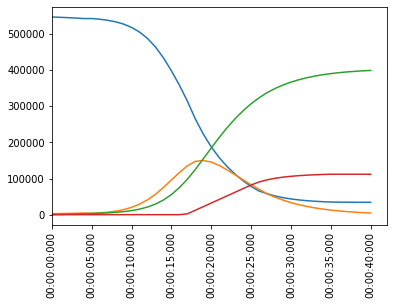

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

result.plot_port('top', 'out', axes=ax, index=0)
result.plot_port('top', 'out', axes=ax, index=1)
result.plot_port('top', 'out', axes=ax, index=2)
result.plot_port('top', 'out', axes=ax, index=3)